In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
import unicodedata
import re
from sklearn.model_selection import train_test_split

In [3]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

May I borrow this book?
¿Puedo tomar prestado este libro?
<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [4]:
data_path = './data_10_1/spa-eng/spa.txt'

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

en, sp = create_dataset(data_path, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [5]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(data_path, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [6]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [7]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
            
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> ¿
311 ----> necesitas
94 ----> algo
14 ----> de
19 ----> mi
32 ----> ,
4 ----> tom
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
22 ----> do
6 ----> you
63 ----> need
17 ----> me
49 ----> ,
5 ----> tom
7 ----> ?
2 ----> <end>


In [8]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [9]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [11]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.decoding_units)

    def call(self, x, hidden, encoding_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, encoding_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [13]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

checkpoint_dir = './10-1_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [14]:
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        encoding_output, encoding_hidden = encoder(inp, encoding_hidden)

        decoding_hidden = encoding_hidden

        decoding_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            decoding_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [15]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5664
Epoch 1 Batch 100 Loss 2.3050
Epoch 1 Batch 200 Loss 1.7303
Epoch 1 Batch 300 Loss 1.5328
Epoch 1 Loss 2.0133
Time taken for 1 epoch 192.02873945236206 sec

Epoch 2 Batch 0 Loss 1.5067
Epoch 2 Batch 100 Loss 1.4738
Epoch 2 Batch 200 Loss 1.2702
Epoch 2 Batch 300 Loss 1.0948
Epoch 2 Loss 1.3962
Time taken for 1 epoch 169.28043389320374 sec

Epoch 3 Batch 0 Loss 1.0985
Epoch 3 Batch 100 Loss 1.1094
Epoch 3 Batch 200 Loss 0.8822
Epoch 3 Batch 300 Loss 0.7151
Epoch 3 Loss 1.0286
Time taken for 1 epoch 168.75251841545105 sec

Epoch 4 Batch 0 Loss 0.7692
Epoch 4 Batch 100 Loss 0.8170
Epoch 4 Batch 200 Loss 0.6078
Epoch 4 Batch 300 Loss 0.4636
Epoch 4 Loss 0.7140
Time taken for 1 epoch 169.04330253601074 sec

Epoch 5 Batch 0 Loss 0.5110
Epoch 5 Batch 100 Loss 0.5733
Epoch 5 Batch 200 Loss 0.4331
Epoch 5 Batch 300 Loss 0.2875
Epoch 5 Loss 0.4824
Time taken for 1 epoch 168.50223565101624 sec

Epoch 6 Batch 0 Loss 0.3328
Epoch 6 Batch 100 Loss 0.3765
Epoch 6 Batch 200

In [16]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    encoding_out, encoding_hidden = encoder(inputs, hidden)

    decoding_hidden = encoding_hidden
    decoding_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, decoding_hidden, attention_weights = decoder(
            decoding_input, decoding_hidden, encoding_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        decoding_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


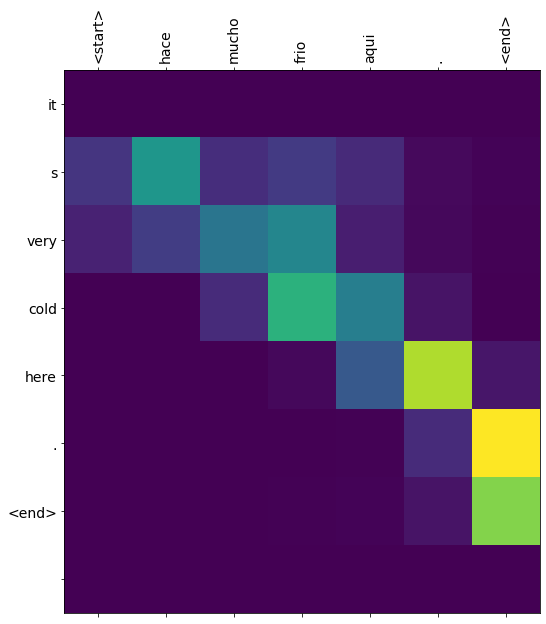

In [17]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


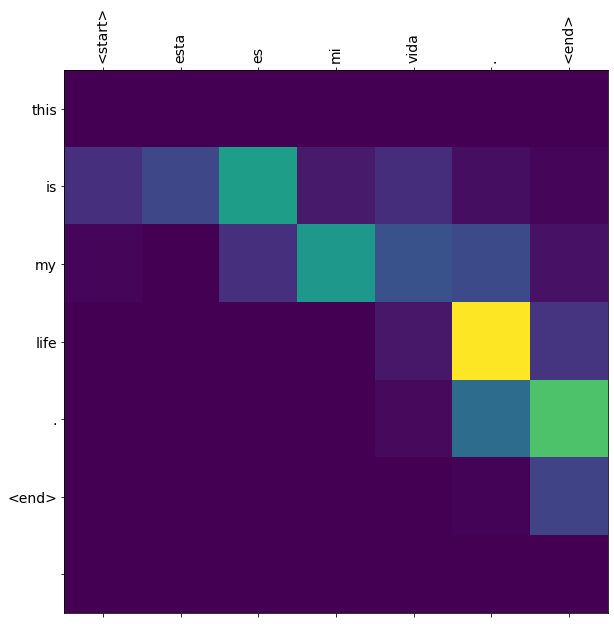

In [18]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


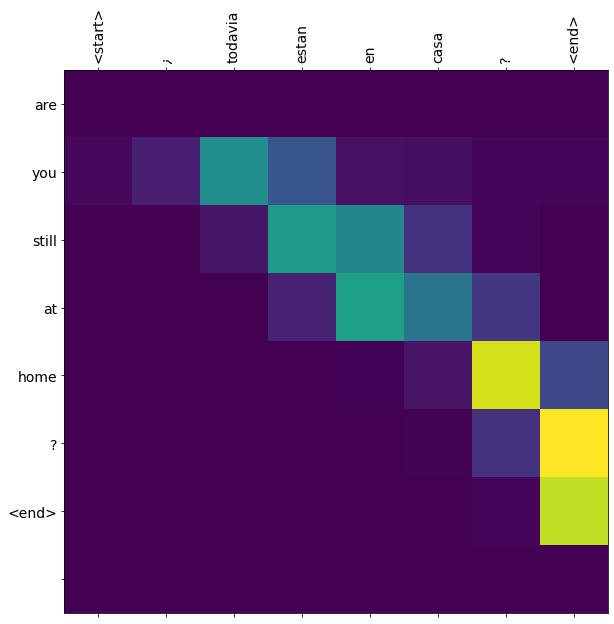

In [19]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to laughed . <end> 


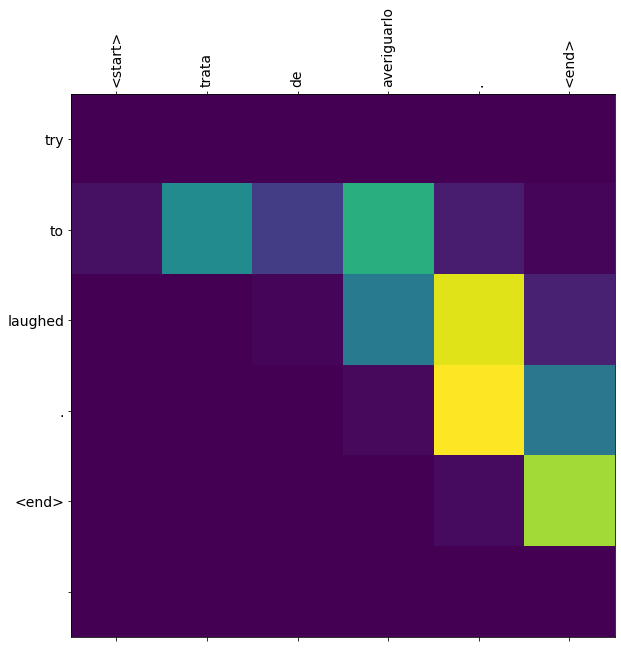

In [20]:
translate(u'trata de averiguarlo.')